# Model Creation

In this notebook, I create a simple Naive Bayes model to identify the language that a test is written in. I create the model using sklearn and then save it locally. 

## Load and explore the data

In this section I load the data from the SQL database, load it into pandas, and explore it.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [3]:
# Connect to the database and add it to a pandas dataframe
sql_db = create_engine("sqlite:///../scraper/language_data.db")
conn = sql_db.connect()
res = conn.execute("SELECT * FROM wiki_data")
df = pd.DataFrame(np.array([row for row in res]))
df = df.rename(columns={0: "article_title", 1: "language", 2: "text"})

In [4]:
# Show a sample of the data
df.head(100)

,article_title,language,text
0,ŽenavmnožnémčísleNezval,pl,Žena v množném čísle – tomik wierszy czeskiego...
1,Eteltyda,pl,Eteltyda Aedilthyda Edilthruda Æthelthida żył...
2,CieńPoego,pl,Cień Poego ang The Poe Shadow – powieść autors...
3,BernabòVisconti,pl,Bernabò Visconti ur 1323 w Mediolanie; zm 18 g...
4,OłeśHonczar,pl,Ołeś Honczar ukr Олесь Терентійович Гончар Ołe...
...,...,...,...
95,Aegyptobiafallugia,sv,Aegyptobia fallugia är en spindeldjursart som ...
96,KekoluotoöiSödraSavolaxNyslott,sv,Kekoluoto är en ö i Finland Den ligger i sjön ...
97,Malgovik,sv,Malgovik sydsamiska: Malkoemahkie är en by och...
98,RíoCachiMayuvattendraglat1931long6527,sv,Río Cachi Mayu är ett vattendrag i Bolivia D...


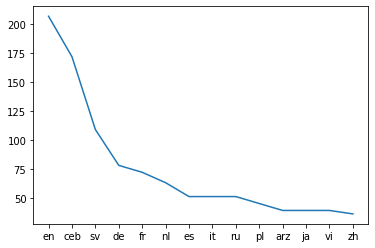

In [5]:
# Plot the number of articles downloaded per language.
plt.plot(df.value_counts("language"))

Notice that Cebuano (_ceb_), a relatively small language from the Philippines, has a very large number of articles - the second most after English! This anomaly was caused by a bot automatically translating articles into Cebuano [source](https://www.quora.com/Why-are-there-so-many-articles-in-the-Cebuano-language-on-Wikipedia). If the goal of the model is to sample a random Wikipedia article and then determine its language, this data distribution is acceptable. However, if this model is intended to be used in other environments - such as identifying the language of texts - then the distribution of data should be modified: less Cebuano, more Chinese - you might want to distribute articles relative to the number of speakers per language. Let's modify the distribution in a very simple way:

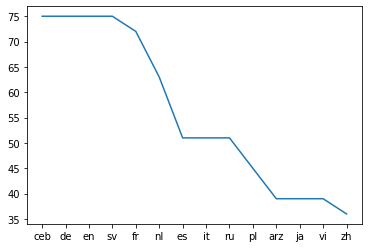

In [6]:
# Generate a query that grabs at most 100 articles from each language.
new_sql_query = """
SELECT *
  FROM (
    SELECT *, RANK()
      OVER (PARTITION BY language ORDER BY title DESC) AS ranks
    FROM wiki_data) x
  WHERE ranks <= 75
"""

# Connect to the database and add it to a pandas dataframe
sql_db = create_engine("sqlite:///../scraper/language_data.db")
conn = sql_db.connect()
res = conn.execute(new_sql_query)
df = pd.DataFrame(np.array([row for row in res]))
df = df.rename(columns={0: "article_title", 1: "language", 2: "text"})

# Plot the number of articles downloaded per language.
plt.plot(df.value_counts("language"))

## Modeling

In this section I create a Multinomial Naive Bayes model that will determine the language given a piece of text.

In [8]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [9]:
# Encode the training data.
text = df["text"]

count_vect = CountVectorizer()
X = count_vect.fit_transform(text)

# Transform this to tfidf counts.
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

# Show the shape of the matrix:
# (num_rows, len_vocabulary)
X.shape

(786, 54472)

In [10]:
# Encode the labels - keep track of this so that the language id can be reconstructed later
labels = df["language"]

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(labels)
y = label_encoder.transform(labels)

# Show the classes
label_encoder.classes_

array(['arz', 'ceb', 'de', 'en', 'es', 'fr', 'it', 'ja', 'nl', 'pl', 'ru',
       'sv', 'vi', 'zh'], dtype=object)

In [11]:
# Go from the numerical code to the language:
label_encoder.inverse_transform([5, 5, 1, 0])

array(['fr', 'fr', 'ceb', 'arz'], dtype=object)

In [12]:
# Make a 80-20 train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Train a multinomial Naive Bayes classifier.
classifier = MultinomialNB().fit(X_train, y_train)

## Testing
In this section, I test out the model and develop some utilities for easily checking its output.

In [14]:
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from matplotlib.pyplot import figure

In [15]:
# Specify the true labels and the model's prediction
y_true = y_test
y_pred = classifier.predict(X_test)

NameError: name 'le' is not defined

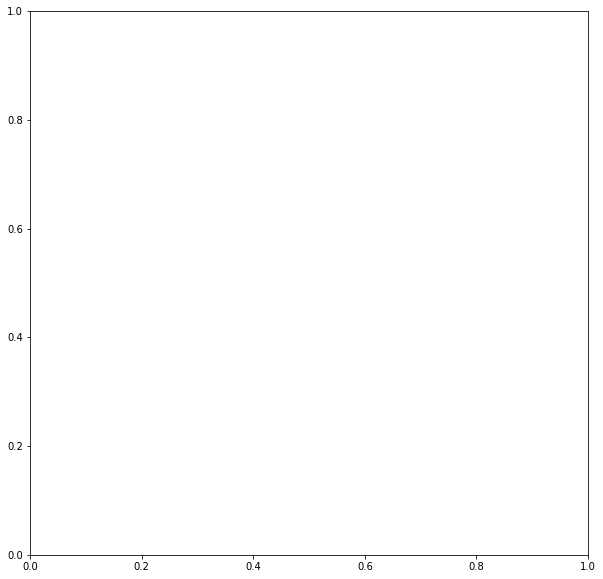

In [16]:
# Plot a confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))

disp = plot_confusion_matrix(classifier, X_test, y_test,
                             display_labels=label_encoder.classes_,
                             cmap=plt.cm.Blues,
#                              normalize="true",
                             ax=ax)
disp.ax_.set_title("Un-normalized confusion matrix")
plt.show()

You can see from the confusion matrix that classification is pretty good! The diagonal from top left to bottom right is "denser" than the off-diagonal, meaning that most articles are being classified correctly.

However, you might notice that some languages are classified particularly poorly: Japanese and Chinese. It happens that these languages don't generally have spaces between their words, so the simple [tokenization](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) performed by our application - splitting on whitespace: `text.split(" ")` - wasn't adequate. This can be fixed, but let's leave it for now!

Also, notice that a lot of articles are misclassified as being English - this is because Naive Bayes is sensitive to the distribution of the data and because English is the most common, there's a bias for classifying things as being English. You can try experimenting with a "flatter" distribution.

Let's also use some mathematical metrics to evaluate the model. The first, accuracy, is pretty simple:

$$ accuracy = \frac{number\ of\ correct\ predictions}{number\ of\ all\ predictions}$$

Precision and recall are two standard ways of evaluating a model. Precision measures the fraction of articles correctly labeled _language X_ (True Positive) out of all articles labeled as _language X_ (True Positives and False Positives).

$$ Precision = \frac{TP}{TP + FP} $$

Recall measures what fraction of a language's articles are correctly classified as belonging to that language. In other words, it's the number of True Positive identifications out of the total number of articles in that language (= True Positive + False Negative).

$$ Precision = \frac{TP}{TP + FN} $$

The $F_1$ score is the weighted average of precision and recall, and is a useful way of combining the two metrics:

$$ F_1 = 2 * \frac{Precision * Recall}{Precision + Recall} $$

In [ ]:
# Accuracy
classifier.score(X_test, y_test)

In [ ]:
# F1 Score
f1_score(y_true, y_pred, average="macro")

When we build new classification models, we should use these metrics to compare the new models to existing ones. It's important to make sure that newer versions of a model don't perform worse!

Now let's build a class that lets us accept some model information and some text and classify it. We can easily swap out models when we have more models to test.

In [ ]:
class ModelPipeline(object):
    def __init__(self, classifier, count_vect, tfidf_transformer, inverse_encoder):
        self.classifier = classifier
        self.count_vect = count_vect
        self.tfidf_transformer = tfidf_transformer
        self.inverse_encoder = inverse_encoder
        
    def classify(self, text):
        counts = self.count_vect.transform(text)
        tfidf = self.tfidf_transformer.transform(counts)
        pred = self.classifier.predict(tfidf)
    
        return self.inverse_encoder.inverse_transform(pred)
    
model = ModelPipeline(classifier, count_vect, tfidf_transformer, label_encoder)

# Surround the text in brackets because this function accepts an entire list of phrases.
model.classify(["This is some English text", "das ist Deutsch", "donde estan el banyo?"])

## Save model
Let's save the model and its version so that we can use it later.

In [ ]:
import joblib

In [ ]:
MODEL_NAME = "NB_Classif"
MODEL_VERSION = "1"
MODEL_PATH = f"models/{MODEL_NAME}/{MODEL_VERSION}"

In [ ]:
joblib.dump(count_vect, f"{MODEL_PATH}/count_vect.pkl")
joblib.dump(tfidf_transformer, f"{MODEL_PATH}/tfidf_transformer.pkl")
joblib.dump(classifier, f"{MODEL_PATH}/classifier.pkl")
joblib.dump(label_encoder, f"{MODEL_PATH}/label_encoder.pkl")